In [1]:
import argparse
import numpy as np
from pprint import pprint
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
from torchvision import datasets, transforms
import os
from blackbox_utils import label_to_onehot, cross_entropy_for_onehot, pixelwise_euclidean_distance
import matplotlib.pyplot as plt
import matplotlib  # 关键：显式
from torch.utils.data import Dataset, DataLoader, Subset
# 指定使用文泉驿微米黑（系统已识别的字体名称）# 获取 matplotlib 缓存目录
cache_dir = matplotlib.get_cachedir()  
# 字体缓存文件名（不同版本可能为 fontlist-v330.json、fontlist.json 等）
font_cache = os.path.join(cache_dir, "fontlist.json")  

# 删除缓存文件
if os.path.exists(font_cache):
    os.remove(font_cache)
    print("✅ 已删除字体缓存，重启内核后生效！")
else:
    print("⚠️ 未找到字体缓存文件，可尝试重启内核。")
plt.rcParams['font.sans-serif'] = ['WenQuanYi Micro Hei']  
# 解决负号显示为方块的问题
plt.rcParams['axes.unicode_minus'] = False  
##########sudo apt update && sudo apt install fonts-wqy-microhei -y  

/environment/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


⚠️ 未找到字体缓存文件，可尝试重启内核。


In [2]:
# ################################################
# ## 轻易不要运行这个代码

# import shutil

# # 配置路径
# source_root = "/home/featurize/data/University-Release/train/street"
# target_dir = "/home/featurize/data/blackbox_data"

# # 确保目标文件夹存在
# if not os.path.exists(target_dir):
#     os.makedirs(target_dir)
#     print(f"创建目标文件夹: {target_dir}")

# # 定义支持的图片扩展名（可根据实际情况补充）
# IMAGE_EXTENSIONS = ('.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff')

# # 遍历所有子文件夹，提取图片
# copied_count = 0
# for root, dirs, files in os.walk(source_root):
#     for filename in files:
#         # 检查文件扩展名是否为图片
#         if filename.lower().endswith(IMAGE_EXTENSIONS):
#             source_path = os.path.join(root, filename)
#             # 处理重名：自动添加序号（如 photo.jpg → photo_1.jpg）
#             target_path = os.path.join(target_dir, filename)
#             if os.path.exists(target_path):
#                 base_name, ext = os.path.splitext(filename)
#                 counter = 1
#                 while True:
#                     new_filename = f"{base_name}_{counter}{ext}"
#                     target_path = os.path.join(target_dir, new_filename)
#                     if not os.path.exists(target_path):
#                         break
#                     counter += 1

#             # （可选）验证图片完整性，避免复制损坏文件
#             try:
#                 with Image.open(source_path) as img:
#                     img.verify()  # 验证图片是否可正常打开
#             except (IOError, SyntaxError) as e:
#                 print(f"跳过无效图片: {source_path}（错误: {e}）")
#                 continue

#             # 复制文件（保留元数据）
#             shutil.copy2(source_path, target_path)
#             ########### print(f"已复制: {source_path} → {target_path}")
#             copied_count += 1
# print(f"\n任务完成！共复制 {copied_count} 张图片到 {target_dir}")

In [3]:
# ------------------- 配置参数 -------------------
batchsize = 1
setpoint = 8####实际为3
h, w = 384, 384
pad = 10
num_images = 3000  # 需要选取的照片数量
target_path = '/home/featurize/data/blackbox_data'  # 目标图片路径
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tt = transforms.ToTensor()#转发为张量
tp = transforms.ToPILImage()#转换为图片
print(f"run in {device}")

run in cuda


数据集共有 2659 张照片，全部使用


findfont: Generic family 'sans-serif' not found because none of the following families were found: WenQuanYi Micro Hei
findfont: Generic family 'sans-serif' not found because none of the following families were found: WenQuanYi Micro Hei
findfont: Generic family 'sans-serif' not found because none of the following families were found: WenQuanYi Micro Hei
findfont: Generic family 'sans-serif' not found because none of the following families were found: WenQuanYi Micro Hei
findfont: Generic family 'sans-serif' not found because none of the following families were found: WenQuanYi Micro Hei
findfont: Generic family 'sans-serif' not found because none of the following families were found: WenQuanYi Micro Hei
findfont: Generic family 'sans-serif' not found because none of the following families were found: WenQuanYi Micro Hei
findfont: Generic family 'sans-serif' not found because none of the following families were found: WenQuanYi Micro Hei
findfont: Generic family 'sans-serif' not found 

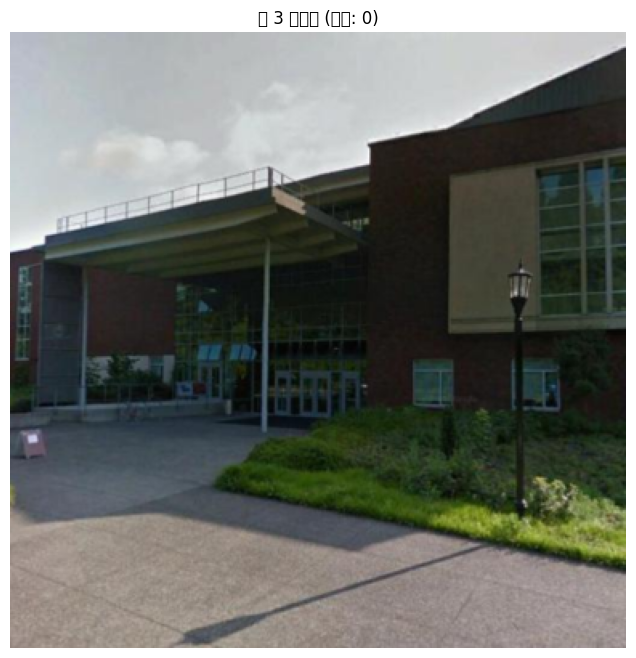

In [4]:
# 自定义数据集
class CustomImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        # 只保留图片文件
        self.image_paths = [
            os.path.join(image_dir, fname) 
            for fname in os.listdir(image_dir) 
            if fname.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))
            and not fname.startswith('.')
        ]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # 加载并返回 PIL 图像
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        
        # 应用预处理转换
        if self.transform:
            image = self.transform(image)
            
        return image, 0  # 返回预处理后的图像和标签 0

# 自定义 collate_fn
def custom_collate(batch):
    return batch[0]  # batch_size=1 时直接返回单个样本

# 定义图像预处理转换
transform = transforms.Compose([
    transforms.Resize((384, 384)),  # 调整图像大小为384×384
    transforms.ToTensor()         # 转换为张量
    # transforms.Normalize(           # 归一化处理
    #     mean=[0.485, 0.456, 0.406],  # ImageNet数据集的均值
    #     std=[0.229, 0.224, 0.225]    # ImageNet数据集的标准差
    
])

# 创建数据集和数据加载器
dataset = CustomImageDataset(target_path, transform=transform)
if len(dataset.image_paths) > 3000:
    dataset.image_paths = dataset.image_paths[:3000]
    print(f"数据集已限制为 {len(dataset.image_paths)} 张照片")
else:
    print(f"数据集共有 {len(dataset.image_paths)} 张照片，全部使用")


# 创建数据加载器（指定自定义 collate_fn）
dataloader = DataLoader(
    dataset,
    batch_size=1,  
    shuffle=False,
    num_workers=0,
    pin_memory=True,
    collate_fn=custom_collate  # 关键修改
)

# 显示第三张照片
image_tensor, label = list(dataloader)[2]  # 获取第 3 张（索引 2）
image_pil = transforms.ToPILImage()(image_tensor)  # 转换回PIL图像用于显示

plt.figure(figsize=(8, 8))
plt.imshow(image_pil)
plt.title(f"第 3 张照片 (标签: {label})")
plt.axis('off')
plt.show()

In [5]:
# image, label = list(dataloader)[2]  # 索引 2 对应第三张照片
# plt.imshow(image)
# plt.show()

In [6]:

# # 转换为batch格式（添加batch维度，模型通常需要[batch, c, h, w]格式）
# preprocessed_img_torch = tt(preprocessed_img)
# preprocessed_img_torch = preprocessed_img_torch.unsqueeze(0)  # 形状从[c, h, w]变为[1, c, h, w]
# label_image_torch = torch.tensor([label_image])  # 标签添加batch维度



In [7]:
from model_black_attack import ft_net
pretrained_path = '/home/featurize/work/RK_net/RK-Net-main/model/pretrain/net_359.pth'  # 绝对路径
# RK-Net/RK-Net-main/model/pretrain/net_359.pth
net = ft_net(751, sp = setpoint).to(device)

# 加载预训练权重（strict=False允许部分参数不匹配，适用于迁移学习）

pretrained_state = torch.load(pretrained_path, map_location=torch.device('cpu'))
net.load_state_dict(pretrained_state, strict=False)
print("Loaded pretrained model from:", pretrained_path)

/environment/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/environment/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loaded pretrained model from: /home/featurize/work/RK_net/RK-Net-main/model/pretrain/net_359.pth


| 索引 | 模块名称                          | 说明                          |     
|------|-----------------------------------|-----------------------------|
| 0    | `model_ft.conv1`                  | 第层：输出[1, 64, 192, 192] |
| 1    | `model_ft.suam1`                  | 第层：输出[1,64,192,192]    |
| 2    | `model_ft.layer1`                 | 第层：输出[1, 256, 96, 96]  |
| 3    | `model_ft.layer2`                 | 第层：输出[1, 512, 48, 48]  |
| 4    | `model_ft.layer3`                 | 第层：输出[1, 1024, 24, 24] |
| 5    | `model_ft.layer4`                 | 第层：输出[1, 2048, 12, 12]|


In [8]:


# class VGG9(nn.Module):
#     def __init__(self, num_classes, sp=4, in_channels=3, fig_size=384):####sp为切割点
#         assert sp<=17 and sp>0
#         super(VGG9, self).__init__()
#         cfg = [32, 64, 128, 128, 256, 256, 512, 512]
#         self.conv1 = nn.Conv2d(in_channels,  cfg[0], 3, 1, 1)
#         self.conv2 = nn.Conv2d(cfg[0], cfg[1], 3, 1, 1)
#         self.conv3 = nn.Conv2d(cfg[1], cfg[2], 3, 1, 1)
#         self.conv4 = nn.Conv2d(cfg[2], cfg[3], 3, 1, 1)
#         self.conv5 = nn.Conv2d(cfg[3], cfg[4], 3, 1, 1)
#         self.conv6 = nn.Conv2d(cfg[4], cfg[5], 3, 1, 1)
#         self.fc1   = nn.Linear(int((fig_size/8)**2)*cfg[5], cfg[6])
#         self.fc2   = nn.Linear(cfg[6], cfg[7])
#         self.fc3   = nn.Linear(cfg[7], num_classes)
#         self.total_module_list = [self.conv1, self.conv2, nn.ReLU(), nn.MaxPool2d(2, 2), 
#                                 self.conv3, self.conv4, nn.ReLU(), nn.MaxPool2d(2, 2),
#                                 self.conv5, self.conv6, nn.ReLU(), nn.MaxPool2d(2, 2),
#                                nn.Flatten(1), self.fc1, nn.ReLU(), self.fc2, nn.ReLU(), self.fc3]
#         self.f = nn.Sequential(*self.total_module_list[0:sp])
#         self.g = nn.Sequential(*self.total_module_list[sp:])

#     def forward(self, x):
#         x_1 = self.f(x)
#         x_cut = x_1.detach().clone()
#         x_out = self.g(x_1)
#         return x_out, x_cut

# net = VGG9(num_classes=751).to(device)#模型名字


In [9]:
# ------------------- 生成新训练集（简化版，无分块） -------------------
new_dataset = []
# save_dataset_path = '/home/featurize/work/magazine/blackbox/blackbox_dataset.pt'
with torch.no_grad():
    for images, labels in dataloader:
        # img_tensor = images.to(device)
        # 模型推理（确保计算在 GPU）
        # img_tensor = images.to(device)  # device 需提前定义（如 'cuda' 或 'cpu'）
        img_tensor = images.unsqueeze(0).to(device)  # 添加 batch_size=1 的维度
        model_output = net.f(img_tensor)    # net 需提前定义（模型实例）
        model_output = model_output.squeeze(0)
        img_tensor = img_tensor.squeeze(0)  # 从 [1, 3, 384, 384] → [3, 384, 384]
        
        # 保存：数据（model_output）和标签（img_tensor）均转为 CPU Tensor
        new_dataset.append((model_output.cpu(), img_tensor.cpu()))
        
        ## 可选：每 100 步清理 GPU 缓存（防止显存溢出）
        # if i % 100 == 0:
        #     torch.cuda.empty_cache()


In [10]:
print(model_output.shape)

torch.Size([512, 48, 48])


In [11]:
# attack_dataset = DataLoader(new_dataset, batch_size=1, shuffle=False)

# # 使用 DataLoader 进行迭代
# for batch_idx, (batch_data, batch_labels) in enumerate(attack_dataset):
#     print(f"批次 {batch_idx} - 数据形状: {batch_data.shape}, 标签形状: {batch_labels.shape}")
    
#     # 在此添加训练逻辑（如传入模型、计算损失等）
#     # output = model(batch_data)
#     # loss = criterion(output, batch_labels)
#     # ...
    
#     # 只展示第一个批次，可删除
    
#     if batch_idx == 2:
#         plt.imshow(tp(batch_labels[0]))
#         plt.show()
#         break
# # print(model_output.shape)
# # print(img_tensor.shape)

In [12]:
# class blackbox_attack(nn.Module):
#     def __init__(self, num_classes, sp=5, in_channels=3, fig_size=192):
#         # 确保 sp 范围有效
#         assert 0 < sp <= 17, "sp 需满足 0 < sp <= 17"
#         super(blackbox_attack, self).__init__()  # 修正继承，原为错误的 VGG9
        
#         # 网络配置（通道数序列）
#         cfg = [32, 64, 128, 128, 256, 256, 512, 512]
        
#         # ------------------- 新增：上采样转置卷积层 -------------------
#         # 目标：将 192×192 放大到 384×384（尺寸翻倍）
#         self.upsample = nn.ConvTranspose2d(
#             in_channels=cfg[1],    # 输入通道数（与 conv1 输出匹配）
#             out_channels=cfg[1],   # 输出通道数（保持与输入一致）
#             kernel_size=3,         # 卷积核大小
#             stride=2,              # 步长=2 → 尺寸×2
#             padding=1,             # 填充
#             output_padding=1,      # 确保输出尺寸精准翻倍（192→384）
#             bias=False             # 配合 BatchNorm 更稳定
#         )
#         self.upsample2 = nn.ConvTranspose2d(
#             in_channels=cfg[1],    # 输入通道数（与 conv1 输出匹配）
#             out_channels=cfg[1],   # 输出通道数（保持与输入一致）
#             kernel_size=3,         # 卷积核大小
#             stride=2,              # 步长=2 → 尺寸×2
#             padding=1,             # 填充
#             output_padding=1,      # 确保输出尺寸精准翻倍（192→384）
#             bias=False             # 配合 BatchNorm 更稳定
#         )
#         # 可选：添加 BatchNorm 和 ReLU 增强非线性（根据需求调整）
#         self.upsample_bn = nn.BatchNorm2d(cfg[1])
#         self.upsample_relu = nn.ReLU(inplace=True)
        
#         # ------------------- 原有卷积层 -------------------
#         self.conv1 = nn.Conv2d(cfg[1], cfg[0], kernel_size=3, stride=1, padding=1)
#         self.conv2 = nn.Conv2d(cfg[0], in_channels, kernel_size=3, stride=1, padding=1)
        
#         # ------------------- 构建模块列表（插入上采样流程） -------------------
#         self.total_module_list = [
#             # 插入上采样流程：64×192×192 → 64×384×384
#             self.upsample, 
#             self.upsample2,
#             self.upsample_bn,     
#             self.upsample_relu,   
#             self.conv1,            
#             nn.ReLU(inplace=True), 
            
#             self.conv2,            
#         ]

#     def forward(self, x):
#         # 按模块列表顺序执行
#         for module in self.total_module_list:
#             x = module(x)
#         return x

In [13]:
from model_black_attack import blackbox_attack0, blackbox_attack5, blackbox_attack7, blackbox_attack8, blackbox_attack9, blackbox_attack3
if setpoint == 6:
    blackbox_net = blackbox_attack5(num_classes=751).to(device)##[256, 96, 96]
if setpoint == 8:
    blackbox_net = blackbox_attack7(num_classes=751).to(device)
if setpoint == 1:
    blackbox_net = blackbox_attack0(num_classes=751).to(device)
if setpoint == 4:
    blackbox_net = blackbox_attack3(num_classes=751).to(device)#和1一样
if setpoint == 7:
    blackbox_net = blackbox_attack5(num_classes=751).to(device)###[256, 96, 96
if setpoint == 9:
    blackbox_net = blackbox_attack8(num_classes=751).to(device)###1024, 24, 24
if setpoint == 10:
    blackbox_net = blackbox_attack9(num_classes=751).to(device)###2948, 12, 12
print(blackbox_net)
weight_path = "w7_attack.pth"  # 明确权重路径
# if os.path.isfile(weight_path):
#     # 加载权重（自动适配设备，避免强制CPU）
#     pretrained_state = torch.load(weight_path, map_location=device)  
#     # 加载到模型（strict=False 兼容结构差异，根据需求调整）
#     blackbox_net.load_state_dict(pretrained_state, strict=False)  

blackbox_attack7(
  (upsample): ConvTranspose2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1), bias=False)
  (upsample2): ConvTranspose2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1), bias=False)
  (upsample3): ConvTranspose2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1), bias=False)
  (upsample_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (upsample_relu): ReLU(inplace=True)
  (conv1): Conv2d(512, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


epoch 0 loss value:0.005709975026547909
epoch 1 loss value:0.010070214048027992
epoch 2 loss value:0.005176282953470945
epoch 3 loss value:0.005423450376838446
epoch 4 loss value:0.00921434536576271
epoch 5 loss value:0.004201882518827915
epoch 6 loss value:0.006014256738126278
epoch 7 loss value:0.0036427893210202456
epoch 8 loss value:0.010348090901970863
epoch 9 loss value:0.006559732835739851
epoch 10 loss value:0.005608854349702597
epoch 11 loss value:0.006827324628829956
epoch 12 loss value:0.0037137034814804792
epoch 13 loss value:0.005096275359392166
epoch 14 loss value:0.004110823851078749
epoch 15 loss value:0.0056442636996507645
epoch 16 loss value:0.002976363990455866
epoch 17 loss value:0.003900800831615925
epoch 18 loss value:0.0029822636861354113
epoch 19 loss value:0.0017875904450193048
训练完成！最终模型已保存至 w7_attack.pth


findfont: Generic family 'sans-serif' not found because none of the following families were found: WenQuanYi Micro Hei
findfont: Generic family 'sans-serif' not found because none of the following families were found: WenQuanYi Micro Hei
findfont: Generic family 'sans-serif' not found because none of the following families were found: WenQuanYi Micro Hei
findfont: Generic family 'sans-serif' not found because none of the following families were found: WenQuanYi Micro Hei
findfont: Generic family 'sans-serif' not found because none of the following families were found: WenQuanYi Micro Hei
/environment/miniconda3/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 34394 (\N{CJK UNIFIED IDEOGRAPH-865A}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/environment/miniconda3/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 25311 (\N{CJK UNIFIED IDEOGRAPH-62DF}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/environment/

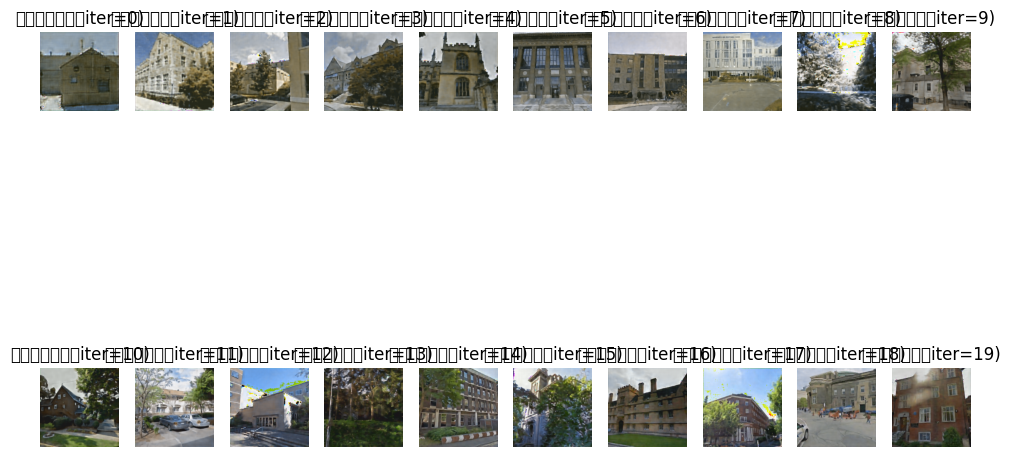

In [14]:
# from model_black_attack import blackbox_attack6, blackbox_attack5, blackbox_attack8, blackbox_attack1
# if setpoint == 6:
#     blackbox_net = blackbox_attack6(num_classes=751).to(device)
# if setpoint == 8:
#     blackbox_net = blackbox_attack8(num_classes=751).to(device)
# print(blackbox_net)
attack_dataset = DataLoader(new_dataset, batch_size=1, shuffle=True)
# 创建数据加载器（全部作为训练集，不划分验证集）
# attack_train_loader = DataLoader(attack_dataset, batch_size=32, shuffle=True, num_workers=2)

# ------------------- 初始化模型、损失函数和优化器 -------------------
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# blackbox_net = blackbox_attack(num_classes=751).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(blackbox_net.parameters(), lr=0.001)
epochs = 20
history_attack = []
# ------------------- 训练循环 -------------------
for epoch in range(epochs):
    # 训练阶段
    blackbox_net.train()
    train_loss = 0.0
    for batch_idx, (model_output, preprocessed_tensor) in enumerate(attack_dataset):#
        ##model_output, preprocessed_tensor形状分别为数据形状: torch.Size([1, 64, 192, 192]), 标签形状: torch.Size([1, 3, 384, 384])
        model_output = model_output.to(device)
        preprocessed_tensor = preprocessed_tensor.to(device)
        
        # 前向传播
        outputs = blackbox_net(model_output)
        loss = criterion(outputs, preprocessed_tensor)
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # train_loss += loss.item() * model_output.size(0)
    history_attack.append(tp(outputs[0].cpu()))
    print(f"epoch {epoch} loss value:{loss}")
    
torch.save(blackbox_net.state_dict(), 'w7_attack.pth')##与blackbox_attack编号统一
print("训练完成！最终模型已保存至 w7_attack.pth")   
plt.figure(figsize=(12, 8))
for i in range(20):
    plt.subplot(2, 10, i + 1)
    plt.imshow(history_attack[i])
    plt.title("虚拟图片展示（iter=%d)" % (i))
    plt.axis('off')


# 保存最终模型


(384, 384)


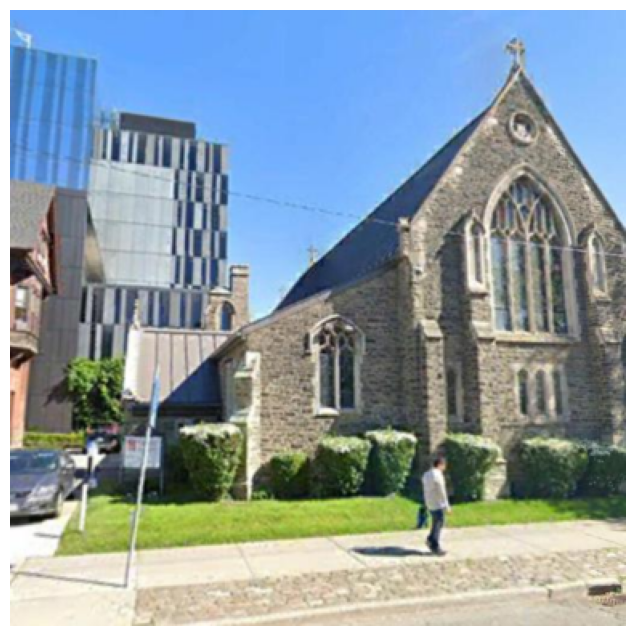

In [15]:
# 获取最后一张照片（索引为 len(dataset)-1 ）
last_idx = len(dataset) - 20
image_attack, label_attack = dataset[last_idx]  

# 转换为 PIL 图像并显示（与之前逻辑一致）
image_show = transforms.ToPILImage()(image_attack)  
print(image_show.size)

plt.figure(figsize=(8, 8))
plt.imshow(image_show)
# plt.title(f"原图")
plt.axis('off')
plt.show()

findfont: Generic family 'sans-serif' not found because none of the following families were found: WenQuanYi Micro Hei
findfont: Generic family 'sans-serif' not found because none of the following families were found: WenQuanYi Micro Hei
findfont: Generic family 'sans-serif' not found because none of the following families were found: WenQuanYi Micro Hei
findfont: Generic family 'sans-serif' not found because none of the following families were found: WenQuanYi Micro Hei
findfont: Generic family 'sans-serif' not found because none of the following families were found: WenQuanYi Micro Hei
findfont: Generic family 'sans-serif' not found because none of the following families were found: WenQuanYi Micro Hei
findfont: Generic family 'sans-serif' not found because none of the following families were found: WenQuanYi Micro Hei
findfont: Generic family 'sans-serif' not found because none of the following families were found: WenQuanYi Micro Hei
findfont: Generic family 'sans-serif' not found 

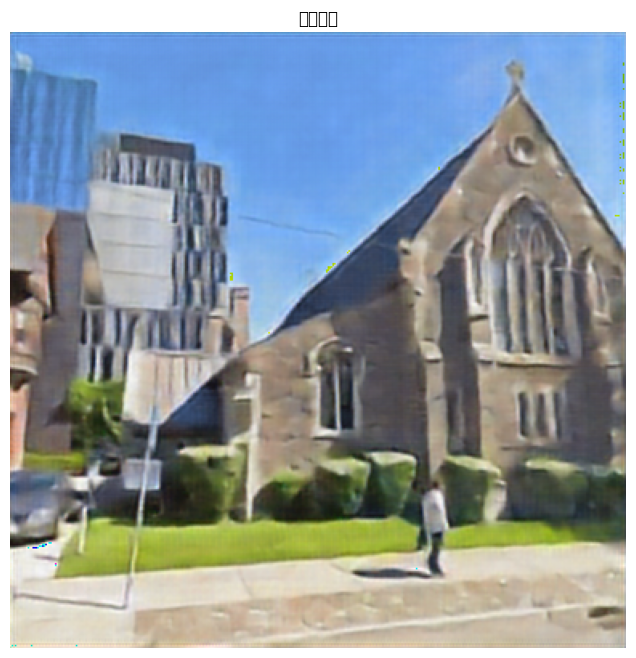

In [16]:
with torch.no_grad():
        image_show = tt(image_show).unsqueeze(0).to(device)  # 添加 batch_size=1 的维度
        show_interdata = net.f(image_show)    # net 需提前定义（模型实例）
        show_interdata = show_interdata
        
with torch.no_grad():
    show_interdata = show_interdata.to(device)
        # 前向传播
    show_outputs = blackbox_net(show_interdata)
plt.figure(figsize=(8, 8))
plt.imshow(tp(show_outputs[0].cpu()))
plt.title(f"结果展示")
plt.axis('off')
plt.show()

findfont: Generic family 'sans-serif' not found because none of the following families were found: WenQuanYi Micro Hei
findfont: Generic family 'sans-serif' not found because none of the following families were found: WenQuanYi Micro Hei
findfont: Generic family 'sans-serif' not found because none of the following families were found: WenQuanYi Micro Hei
findfont: Generic family 'sans-serif' not found because none of the following families were found: WenQuanYi Micro Hei
findfont: Generic family 'sans-serif' not found because none of the following families were found: WenQuanYi Micro Hei
findfont: Generic family 'sans-serif' not found because none of the following families were found: WenQuanYi Micro Hei
findfont: Generic family 'sans-serif' not found because none of the following families were found: WenQuanYi Micro Hei
findfont: Generic family 'sans-serif' not found because none of the following families were found: WenQuanYi Micro Hei
findfont: Generic family 'sans-serif' not found 

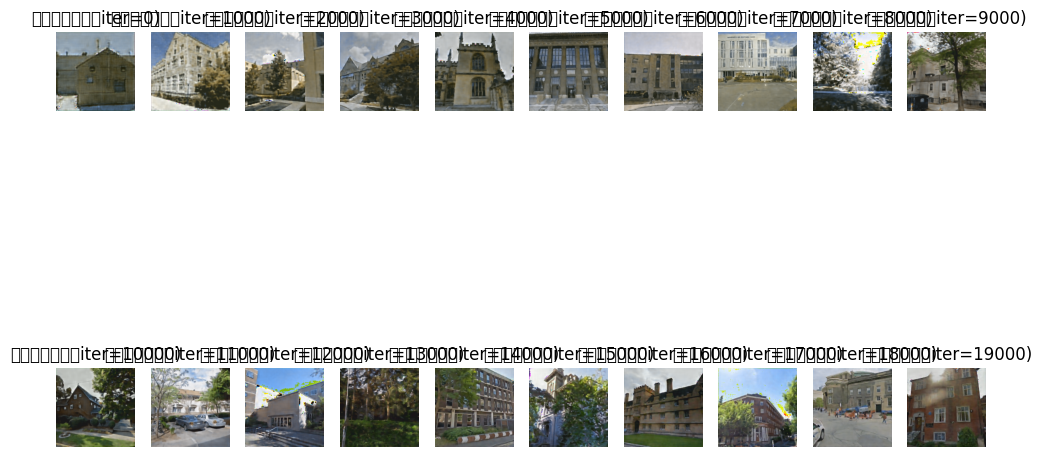

In [17]:
plt.figure(figsize=(12, 8))
for i in range(20):
    plt.subplot(2, 10, i + 1)
    plt.imshow(history_attack[i])
    plt.title("虚拟图片展示（iter=%d)" % (i * 1000))
    plt.axis('off')

plt.show()


In [18]:
tt = transforms.ToTensor()#转发为张量
tp = transforms.ToPILImage()#转换为图片
def image2prob(image_dummy):
    image_dummy_tensor = tt(image_dummy)
    # 计算三通道总和并对每个通道分别归一化
    total_sum = image_dummy_tensor.sum(dim=(1, 2))
    image_dummy_norm = image_dummy_tensor / total_sum.view(-1, 1, 1)
    dummy_prob = F.softmax(image_dummy_norm.view(-1), dim=0)
    return dummy_prob

# attack_image = dummy_data.detach().clone()
#print(type(gt_data))
# image_dummy = history[9]
attack_prob = image2prob(tp(show_outputs[0]))
ture_prob = image2prob(tp(image_show[0]))
kl_div = F.kl_div(ture_prob.log(), attack_prob, reduction='batchmean')
print(abs(kl_div))

tensor(4.1692e-13)


In [19]:
def ssim(img1, img2, window_size=11, size_average=True):
    """
    计算两张图片的结构相似性指数(SSIM)
    
    参数:
        img1: 张量，形状为[batch, channels, height, width]
        img2: 张量，形状为[batch, channels, height, width]
        window_size: 高斯窗口大小
        size_average: 是否对批次和通道取平均
    
    返回:
        ssim值，范围[-1, 1]，越接近1表示越相似
    """
    # 确保输入是浮点型（此时 img1、img2 已是张量，可直接操作）
    img1 = img1.float()
    img2 = img2.float()
    
    # 获取输入尺寸
    batch, channels, height, width = img1.size()
    
    # 修正创建高斯窗口的方式，使用张量进行计算
    x = torch.arange(window_size).float()  # 创建张量来承载x的取值，转换为浮点型
    numerator = -(x - window_size // 2) ** 2
    denominator = float(2 * (window_size // 4) ** 2)
    gauss = torch.exp(numerator / denominator)
    gauss = gauss / gauss.sum()
    window_1d = gauss.unsqueeze(1)
    window_2d = window_1d.mm(window_1d.t()).float().unsqueeze(0).unsqueeze(0)
    window = window_2d.expand(channels, 1, window_size, window_size).contiguous()
    
    # 将窗口移动到与输入相同的设备
    if img1.is_cuda:
        window = window.cuda(img1.get_device())
    window = window.to(img1.device)
    
    # 计算均值
    mu1 = F.conv2d(img1, window, padding=window_size//2, groups=channels)
    mu2 = F.conv2d(img2, window, padding=window_size//2, groups=channels)
    
    # 计算方差和协方差
    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2
    
    sigma1_sq = F.conv2d(img1*img1, window, padding=window_size//2, groups=channels) - mu1_sq
    sigma2_sq = F.conv2d(img2*img2, window, padding=window_size//2, groups=channels) - mu2_sq
    sigma12 = F.conv2d(img1*img2, window, padding=window_size//2, groups=channels) - mu1_mu2
    
    # SSIM公式
    C1 = 0.01**2
    C2 = 0.03**2
    
    ssim_map = ((2*mu1_mu2 + C1) * (2*sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))
    
    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)

# similarity = ssim(tp(show_outputs[0]), tp(image_show[0]))
similarity = ssim(show_outputs, image_show)
print(f"相似度为{similarity}")

相似度为0.7772316932678223
